# Initalization: 
## Loading the Data and Displaying it to get an idea of the data loaded: 

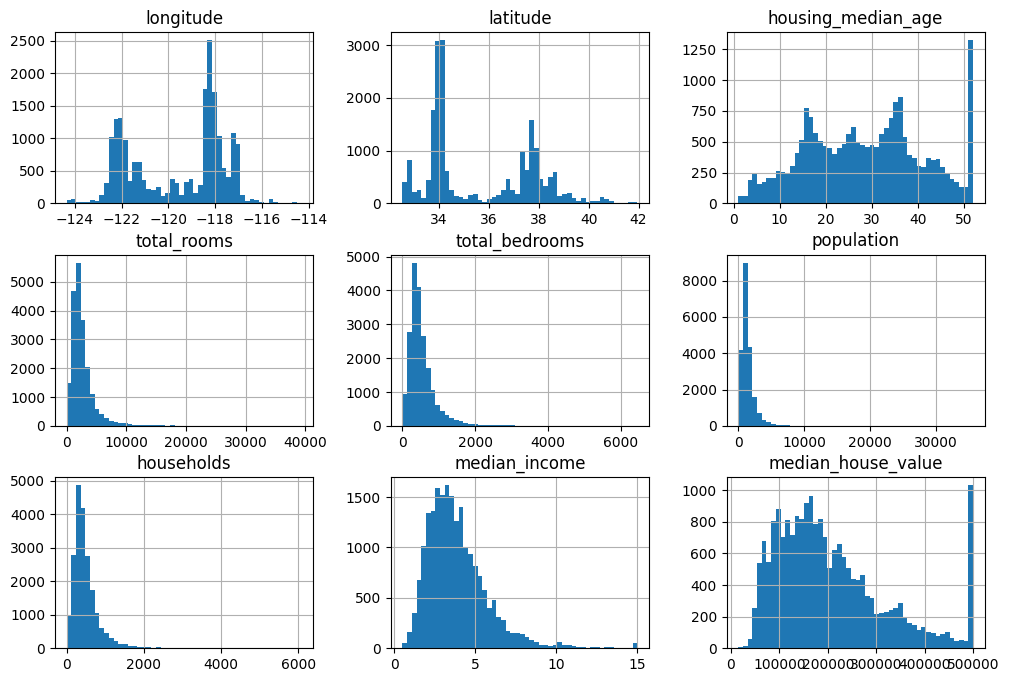

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import os
import numpy as np
import sklearn 

def load_housing_data(housing_path="datasets/housing"):
 csv_path = os.path.join(housing_path, "housing.csv") 
 return pd.read_csv(csv_path)
 

housing=load_housing_data() 
housing.head()
housing.hist(bins=50, figsize=(12, 8)) 
plt.show()

    

## Creating a training set by computing the hash function and using Longitude and Latitude as identifiers (optional): 

### We can instead use this simple line to generate a random test set

## We will however be using stratified sampling so the below code is the one we will use

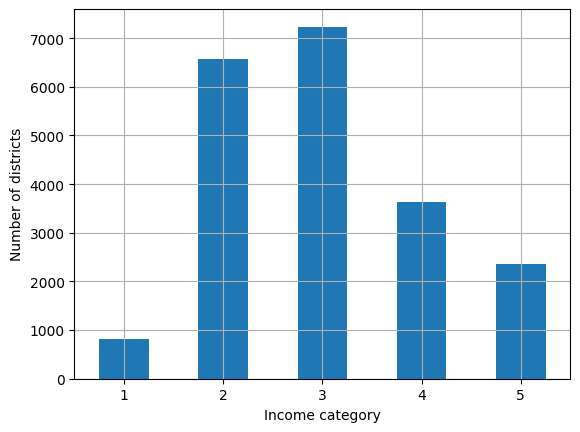

In [2]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf], 
                               labels=[1, 2, 3, 4, 5]) 

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True) 
plt.xlabel("Income category") 
plt.ylabel("Number of districts") 
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)
#For testing  
strat_test_set["income_cat"].value_counts() / len(strat_test_set) 
for set_ in (strat_train_set, strat_test_set): 
    set_.drop("income_cat", axis=1, inplace=True) # Deletes the temporary income_cat column

<Axes: xlabel='longitude', ylabel='latitude'>

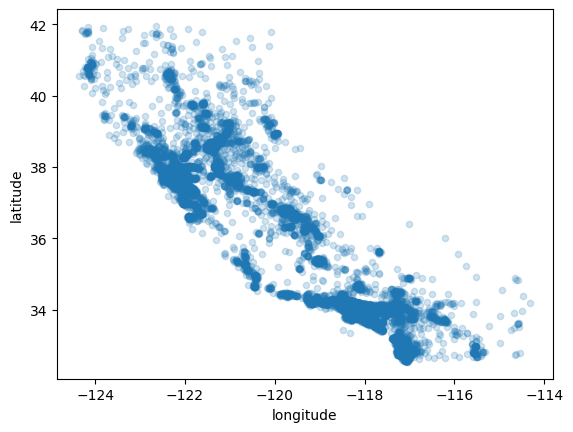

In [14]:
housing=strat_train_set.copy()
#housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter",x="longitude", y="latitude",alpha=0.2)